In [1]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

In [2]:
def load_evaluation_summary(summary_file="/data/jane/math_gender/2_answer_math_qs/evaluation_results/evaluation_summary.json"):
    """Load the evaluation summary JSON file."""
    with open(summary_file, 'r') as f:
        return json.load(f)

summary_data = load_evaluation_summary()
print(f"Loaded {len(summary_data)} evaluation results")

Loaded 72 evaluation results


In [3]:
def parse_results(summary_data):
    """Parse summary data into a structured DataFrame."""
    records = []
    
    for key, metadata in summary_data.items():
        # Parse key format: "model_context"
        parts = key.rsplit('_', 1)
        if len(parts) == 2:
            model = parts[0]
            context = parts[1]
        else:
            continue
            
        records.append({
            'model': model,
            'context': context,
            'accuracy': metadata['accuracy'],
            'correct_answers': metadata['correct_answers'],
            'total_questions': metadata['total_questions']
        })
    
    return pd.DataFrame(records)

df = parse_results(summary_data)
print(f"\nDataFrame shape: {df.shape}")
print(f"\nModels found: {df['model'].unique().tolist()}")
print(f"\nContexts found: {df['context'].unique().tolist()}")



DataFrame shape: (72, 5)

Models found: ['gpt-4o', 'qwen-coder', 'llama-4', 'deepseek-r1']

Contexts found: ['cars', 'baking', 'construction', 'cooking', 'dance', 'fashion', 'finance', 'fishing', 'gardening', 'hiking', 'knitting', 'makeup', 'romance novels', 'shopping', 'sports', 'video games', 'weightlifting', 'woodworking']


In [6]:
# set gendered context colors
first_half_contexts = [
    'cooking', 'gardening', 'fashion', 'dance', 'baking', 
    'makeup', 'shopping', 'romance novels', 'knitting'
]

second_half_contexts = [
    'construction', 'sports', 'video games', 'cars', 'weightlifting',
    'finance', 'fishing', 'woodworking', 'hiking'
]

light_pink = '#FFB6C1'
light_blue = '#ADD8E6'

def get_context_color(context):
    """Return color based on context group."""
    if context in first_half_contexts:
        return light_pink
    elif context in second_half_contexts:
        return light_blue
    else:
        return '#CCCCCC'  # Gray for unknown contexts

df['color'] = df['context'].apply(get_context_color)


In [7]:
def create_model_visualization(df, model_name, output_dir="evaluation_results/plots"):
    """Create accuracy visualization for a single model."""
    
    # Filter data for this model
    model_data = df[df['model'] == model_name].copy()
    
    if model_data.empty:
        print(f"No data found for model: {model_name}")
        return
    
    # Sort by context order (first half, then second half)
    all_contexts = first_half_contexts + second_half_contexts
    model_data['context_order'] = model_data['context'].apply(
        lambda x: all_contexts.index(x) if x in all_contexts else 999
    )
    model_data = model_data.sort_values('context_order')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create bar plot
    bars = ax.bar(
        range(len(model_data)),
        model_data['accuracy'],
        color=model_data['color'],
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8
    )
    
    # Customize plot
    ax.set_xlabel('Context', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title(f'Model Performance: {model_name.upper()}', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(range(len(model_data)))
    ax.set_xticklabels(model_data['context'], rotation=45, ha='right')
    
    # Set y-axis limits
    ax.set_ylim(0, 100)
    
    # Add horizontal grid
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(model_data.iterrows()):
        height = row['accuracy']
        ax.text(i, height + 1.5, f'{height:.1f}%', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=light_pink, edgecolor='black', label='Group 1 (Cooking - Knitting)'),
        Patch(facecolor=light_blue, edgecolor='black', label='Group 2 (Construction - Hiking)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
    
    # Add average line
    avg_accuracy = model_data['accuracy'].mean()
    ax.axhline(y=avg_accuracy, color='red', linestyle='--', linewidth=2, 
               label=f'Average: {avg_accuracy:.1f}%', alpha=0.7)
    
    # Update legend to include average
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize=11)
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, f'{model_name}_accuracy.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved plot to: {output_file}")
    
    return fig

Generating visualizations for 4 models...

Creating plot for: gpt-4o
Saved plot to: evaluation_results/plots/gpt-4o_accuracy.png


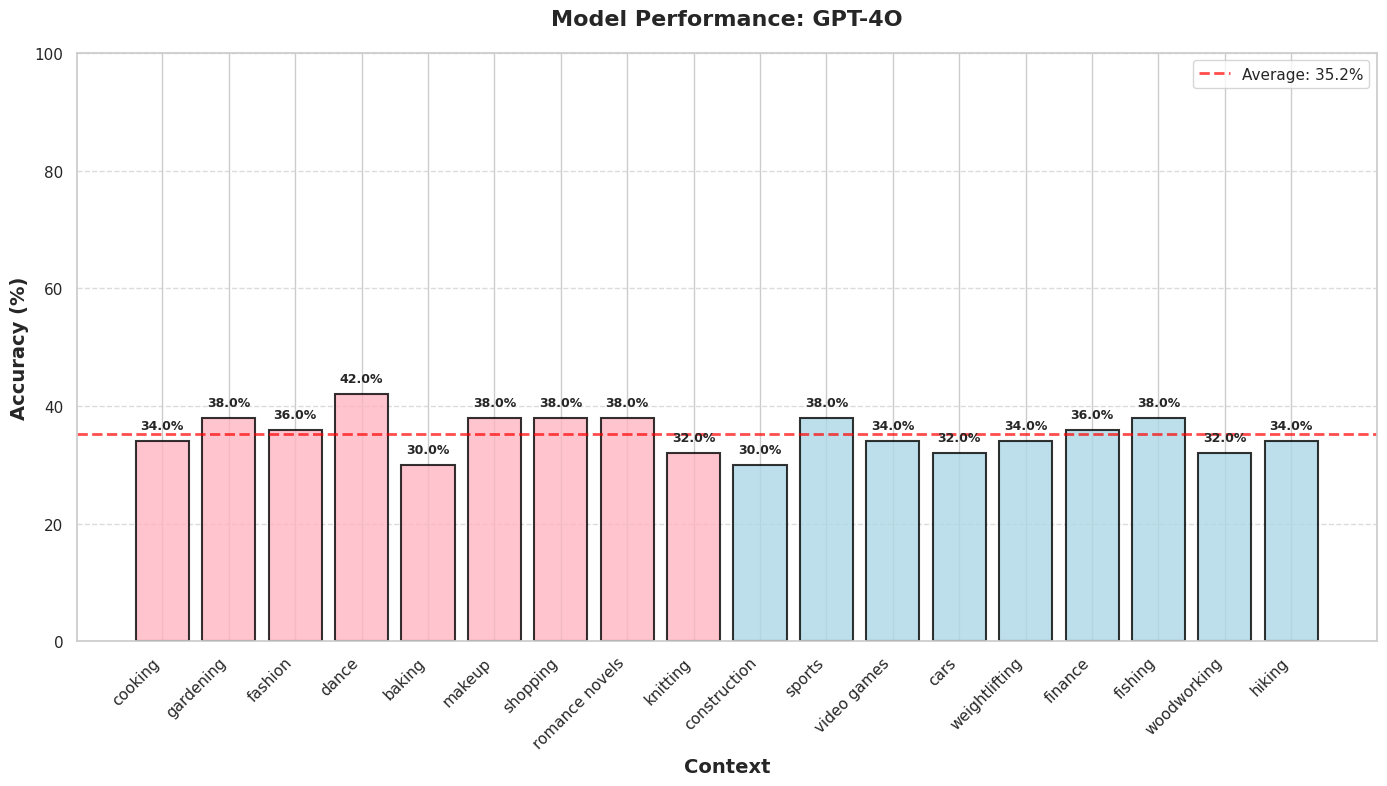


Creating plot for: qwen-coder
Saved plot to: evaluation_results/plots/qwen-coder_accuracy.png


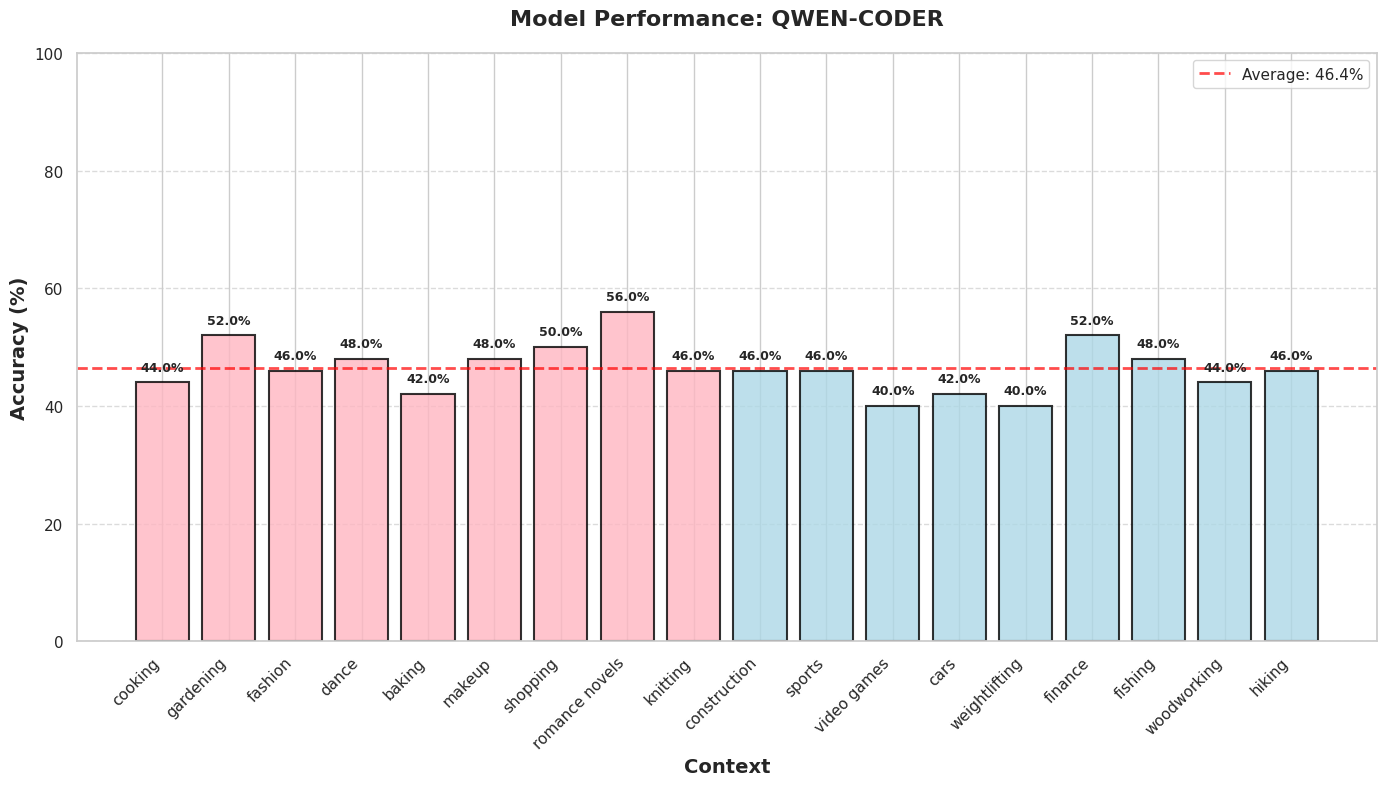


Creating plot for: llama-4
Saved plot to: evaluation_results/plots/llama-4_accuracy.png


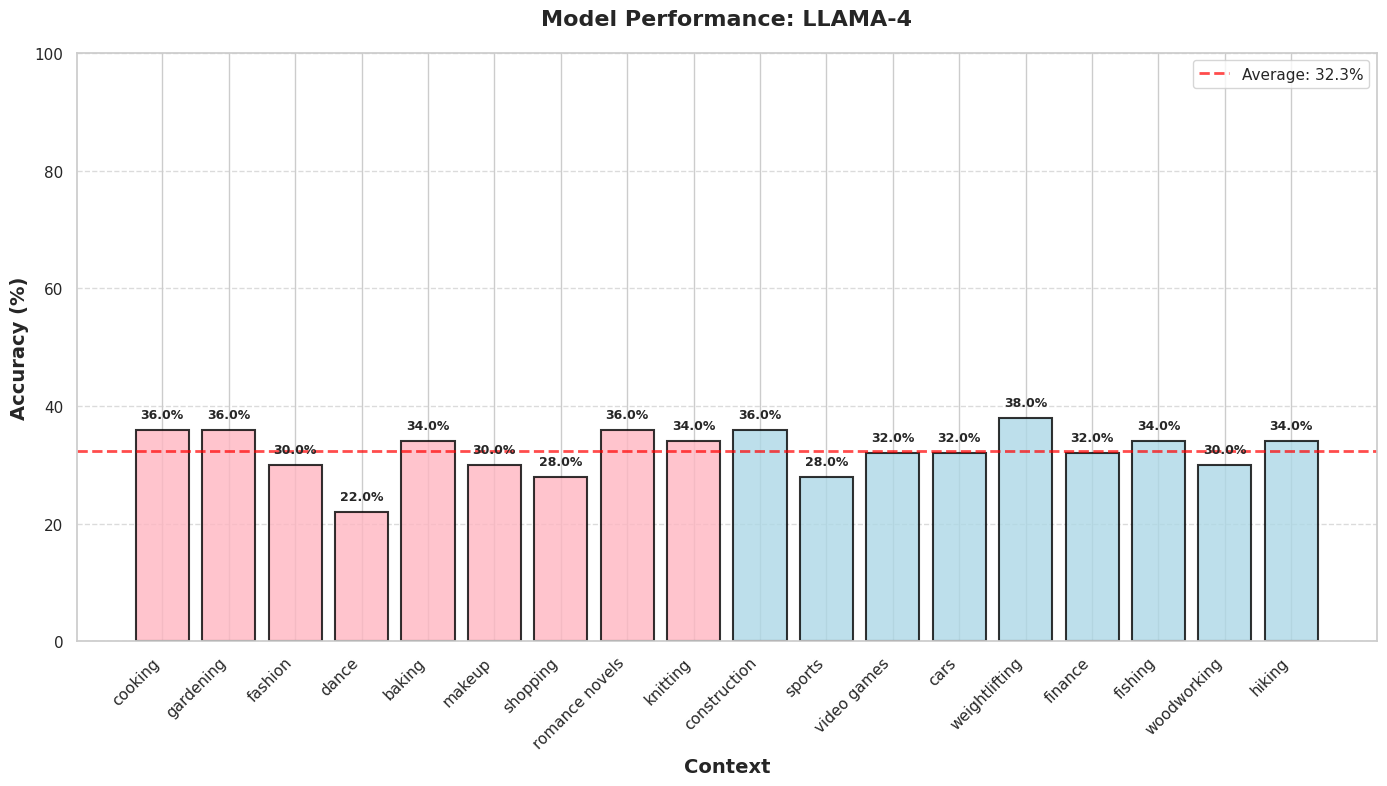


Creating plot for: deepseek-r1
Saved plot to: evaluation_results/plots/deepseek-r1_accuracy.png


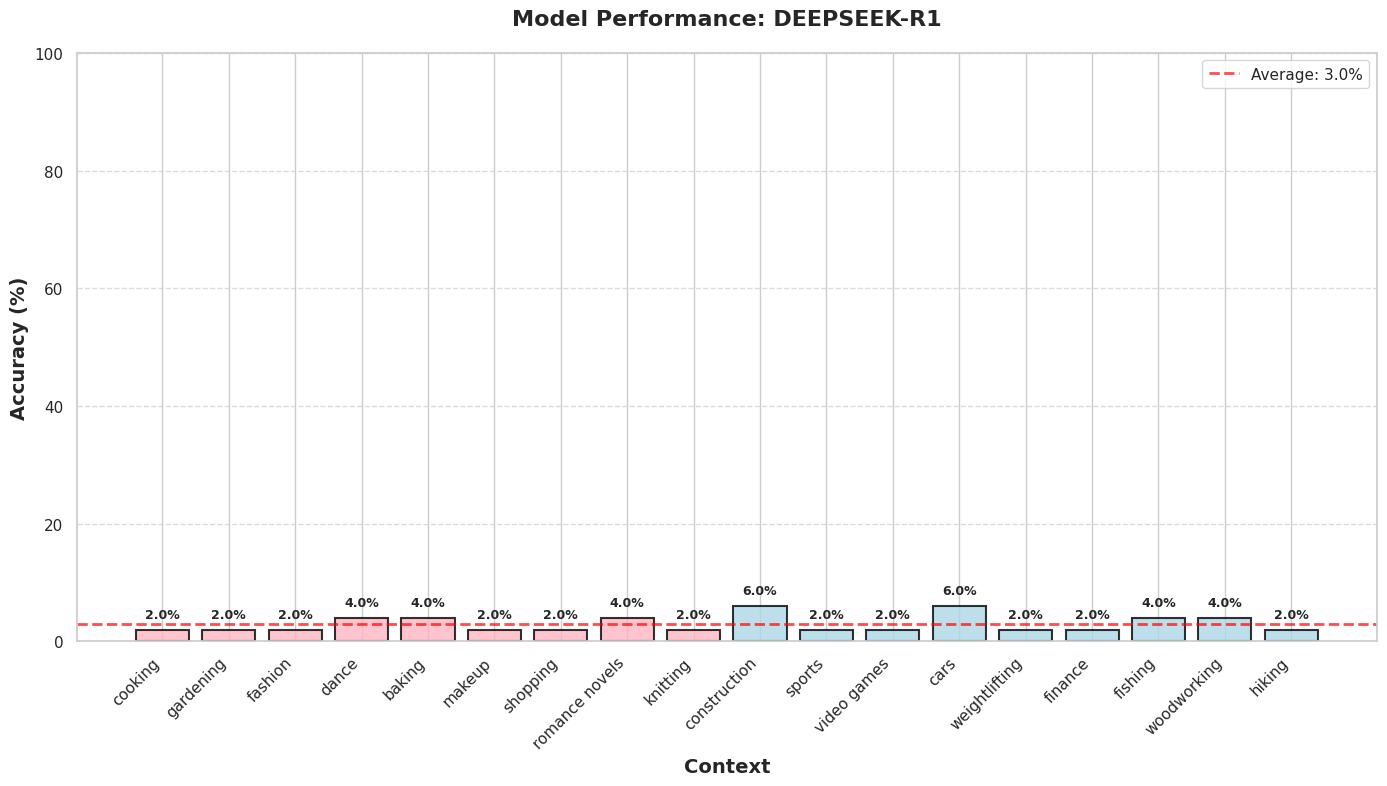



Completed! Generated 4 visualizations.


In [8]:
models = df['model'].unique()

print(f"Generating visualizations for {len(models)} models...\n")

figures = {}
for model in models:
    print(f"Creating plot for: {model}")
    fig = create_model_visualization(df, model)
    if fig:
        figures[model] = fig
        plt.show()
    print()

print(f"\nCompleted! Generated {len(figures)} visualizations.")

Saved comparison plot to: evaluation_results/plots/all_models_comparison.png


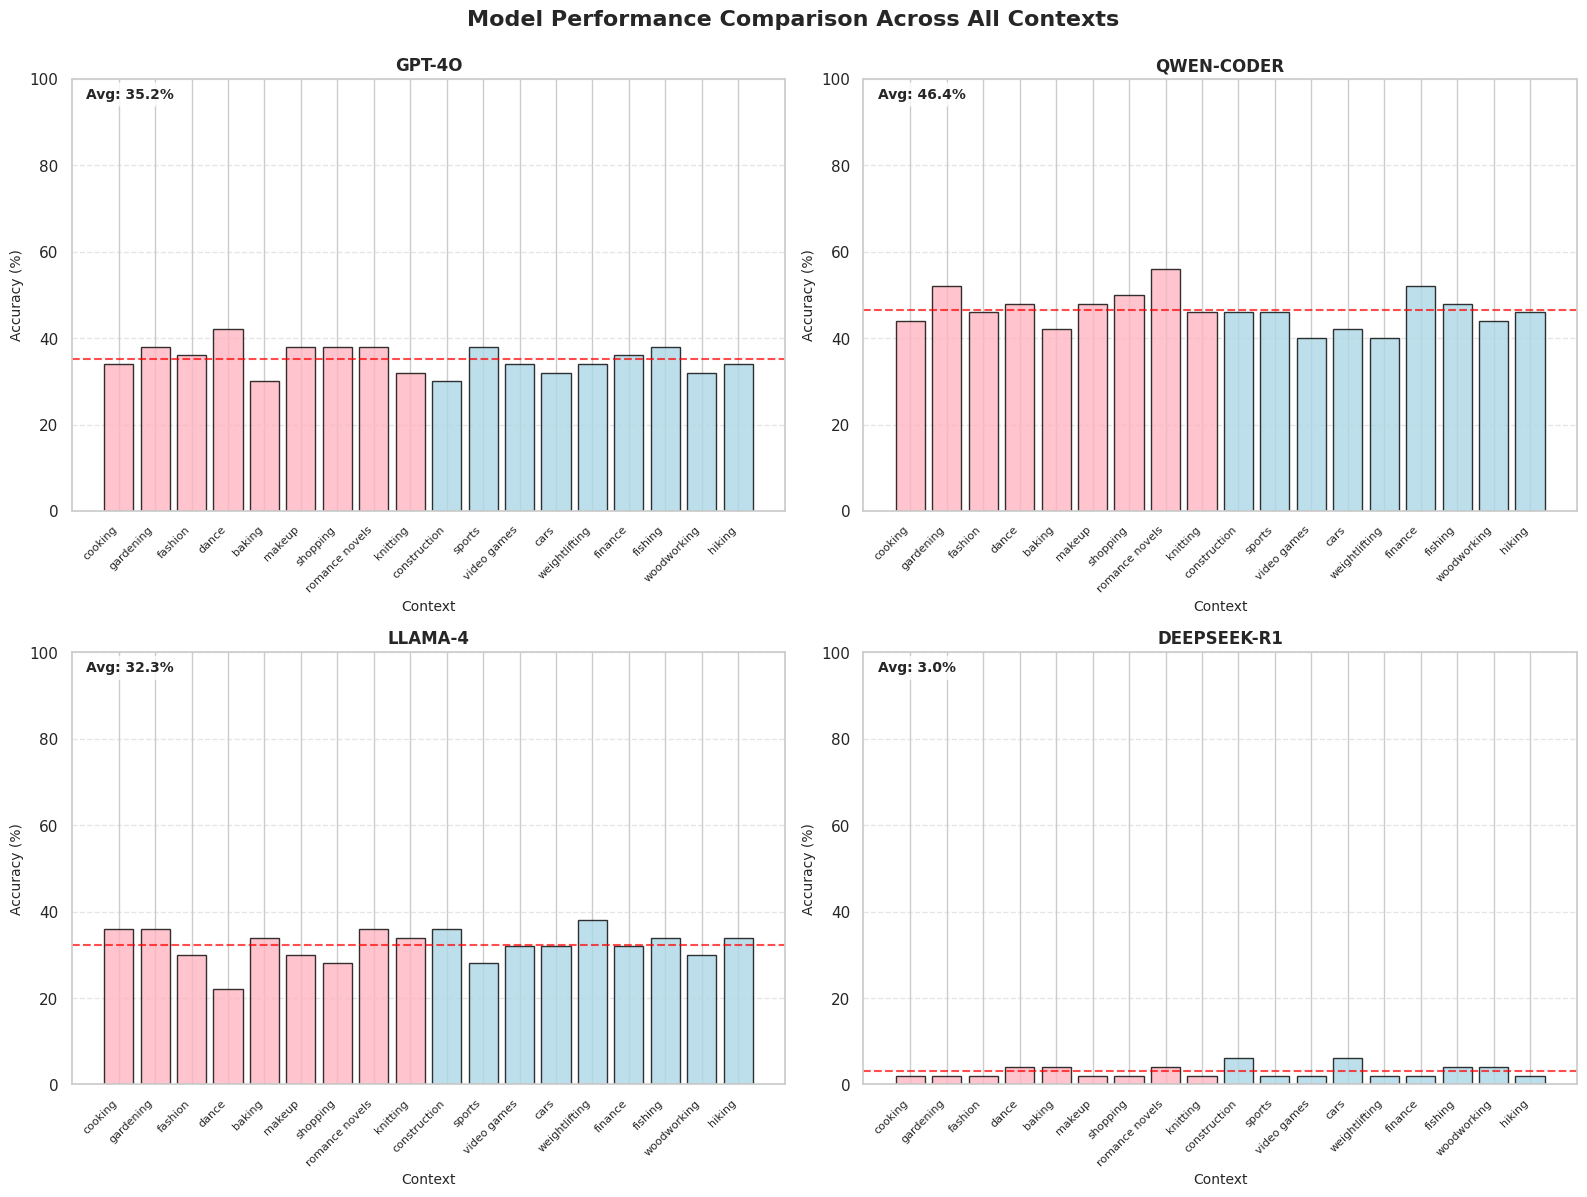

In [9]:
def create_comparison_plot(df, output_dir="evaluation_results/plots"):
    """Create a comparison plot showing all models side by side."""
    
    models = df['model'].unique()
    contexts = first_half_contexts + second_half_contexts
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, model in enumerate(models):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        model_data = df[df['model'] == model].copy()
        
        # Sort by context order
        model_data['context_order'] = model_data['context'].apply(
            lambda x: contexts.index(x) if x in contexts else 999
        )
        model_data = model_data.sort_values('context_order')
        
        # Create bar plot
        ax.bar(range(len(model_data)), model_data['accuracy'], 
               color=model_data['color'], edgecolor='black', 
               linewidth=1, alpha=0.8)
        
        # Customize
        ax.set_title(f'{model.upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Context', fontsize=10)
        ax.set_ylabel('Accuracy (%)', fontsize=10)
        ax.set_ylim(0, 100)
        ax.set_xticks(range(len(model_data)))
        ax.set_xticklabels(model_data['context'], rotation=45, ha='right', fontsize=8)
        ax.yaxis.grid(True, linestyle='--', alpha=0.5)
        
        # Add average line
        avg = model_data['accuracy'].mean()
        ax.axhline(y=avg, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.text(0.02, 0.98, f'Avg: {avg:.1f}%', transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide unused subplots
    for idx in range(len(models), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Model Performance Comparison Across All Contexts', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'all_models_comparison.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Saved comparison plot to: {output_file}")
    
    return fig

comparison_fig = create_comparison_plot(df)
plt.show()

In [10]:
def create_summary_table(df):
    """Create a summary statistics table."""
    summary = df.groupby('model').agg({
        'accuracy': ['mean', 'std', 'min', 'max'],
        'total_questions': 'first'
    }).round(2)
    
    summary.columns = ['Mean Accuracy', 'Std Dev', 'Min Accuracy', 'Max Accuracy', 'Questions']
    summary = summary.sort_values('Mean Accuracy', ascending=False)
    
    return summary

summary_table = create_summary_table(df)
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(summary_table)
print("="*70)


SUMMARY STATISTICS
             Mean Accuracy  Std Dev  Min Accuracy  Max Accuracy  Questions
model                                                                     
qwen-coder           46.44     4.26          40.0          56.0         50
gpt-4o               35.22     3.30          30.0          42.0         50
llama-4              32.33     3.90          22.0          38.0         50
deepseek-r1           3.00     1.41           2.0           6.0         50


In [11]:
def analyze_context_groups(df):
    """Compare performance between first and second half contexts."""
    
    results = []
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        
        first_half_acc = model_data[model_data['context'].isin(first_half_contexts)]['accuracy'].mean()
        second_half_acc = model_data[model_data['context'].isin(second_half_contexts)]['accuracy'].mean()
        
        results.append({
            'model': model,
            'Group 1 (Pink)': first_half_acc,
            'Group 2 (Blue)': second_half_acc,
            'Difference': first_half_acc - second_half_acc
        })
    
    return pd.DataFrame(results).round(2)

group_comparison = analyze_context_groups(df)
print("\n" + "="*70)
print("CONTEXT GROUP COMPARISON")
print("="*70)
print(group_comparison)
print("="*70)
print("\nNote: Positive difference means better performance on Group 1 (Pink) contexts")



CONTEXT GROUP COMPARISON
         model  Group 1 (Pink)  Group 2 (Blue)  Difference
0       gpt-4o           36.22           34.22        2.00
1   qwen-coder           48.00           44.89        3.11
2      llama-4           31.78           32.89       -1.11
3  deepseek-r1            2.67            3.33       -0.67

Note: Positive difference means better performance on Group 1 (Pink) contexts
